In [1]:
#importing needed libraries
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot

In [2]:
#Loading counties related data
data = pd.read_csv('us-counties.csv')
data.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [3]:
data.fips.nunique()

2882

In [4]:
#Aggregating cases and deaths by counties
data_grouped = data.groupby(['county','fips']).sum()
data_grouped.reset_index(level=0, inplace=True)
data_grouped.head()

,county,cases,deaths
fips,,,
45001.0,Abbeville,758,0
22001.0,Acadia,4396,254
51001.0,Accomack,5669,85
16001.0,Ada,23080,445
19001.0,Adair,63,0


In [5]:
#Loading spatial data on counties acquired from the following link - https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2019&layergroup=Counties+%28and+equivalent%29
spatial_data = gpd.read_file('tl_2019_us_county.shp')
spatial_data.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016819475,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


In [6]:
#Making necessary conversions to ease joins
data_grouped.index=data_grouped.index.astype(int)
spatial_data.GEOID = spatial_data.GEOID.astype(int)

In [7]:
spatial_data.shape

(3233, 18)

In [8]:
#Joining spatial data with case data
sdat = pd.merge(spatial_data,data_grouped,how='left',left_on=spatial_data.GEOID,right_on=data_grouped.index)
sdat = sdat.drop(columns=['key_0'])
sdat = sdat[sdat['county'].notna()]
sdat.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,county,cases,deaths
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",Cuming,157.0,0.0
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,None,A,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",Wahkiakum,73.0,0.0
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,None,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790...",Lancaster,6254.0,35.0
6,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,None,A,2089691755,18198481,+43.6674723,-096.7957261,"POLYGON ((-97.12928 43.58683, -97.12920 43.596...",Minnehaha,49746.0,279.0
9,21,053,00516873,21053,Clinton,Clinton County,06,H1,G4020,None,...,None,A,510875755,21152699,+36.7272577,-085.1360977,"POLYGON ((-85.23910 36.76983, -85.23443 36.786...",Clinton,80.0,0.0


In [9]:
#Getting centroid values and removing data for Alaska
sdat["x"] = sdat.centroid.map(lambda p: p.x)
sdat["y"] = sdat.centroid.map(lambda p: p.y)
sdat = sdat[sdat['x'] > -130]
sdat.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,county,cases,deaths,x,y
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",Cuming,157.0,0.0,-96.787400,41.916403
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,680962890,61582307,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",Wahkiakum,73.0,0.0,-123.433470,46.291134
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790...",Lancaster,6254.0,35.0,-96.687756,40.784174
6,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,2089691755,18198481,+43.6674723,-096.7957261,"POLYGON ((-97.12928 43.58683, -97.12920 43.596...",Minnehaha,49746.0,279.0,-96.791437,43.674178
9,21,053,00516873,21053,Clinton,Clinton County,06,H1,G4020,None,...,510875755,21152699,+36.7272577,-085.1360977,"POLYGON ((-85.23910 36.76983, -85.23443 36.786...",Clinton,80.0,0.0,-85.136014,36.727482


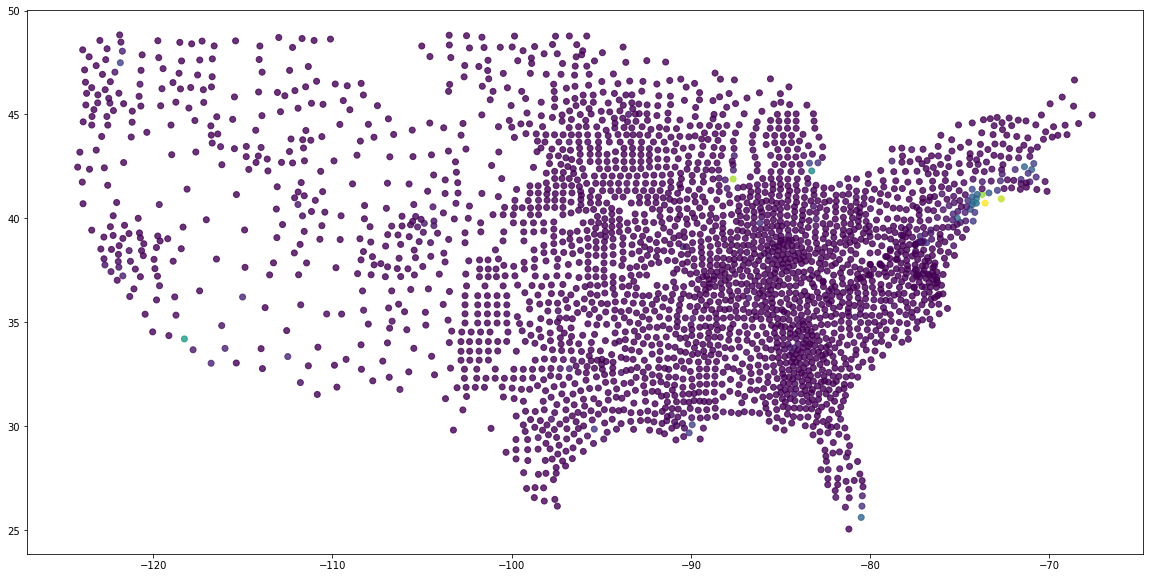

In [9]:
#Plotting centroids with magnitudes
plt.figure(figsize=(20,10))
plt.scatter(y= sdat.y, x = sdat.x , c = sdat.cases, alpha=0.8);
plt.show()

In [11]:
#Learning spatial weights for analysing Spatial Autocorrelation amongst datapoints
y = sdat['cases'].values
w = Queen.from_dataframe(sdat)
w.transform = 'r'

('WARNING: ', 996, ' is an island (no neighbors)')
('WARNING: ', 2301, ' is an island (no neighbors)')


/Users/akashyadav/Desktop/nyuclass/python3.8based/lib/python3.8/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 996, 2301.
  warnings.warn(message)


In [13]:
from esda.moran import Moran

w = Queen.from_dataframe(sdat)
moran = Moran(y, w)
moran.I

('WARNING: ', 996, ' is an island (no neighbors)')
('WARNING: ', 2301, ' is an island (no neighbors)')


/Users/akashyadav/Desktop/nyuclass/python3.8based/lib/python3.8/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 996, 2301.
  warnings.warn(message)


0.48777119923505297

Positive Spatial Autocorrelation exists amongst counties

In [14]:
from splot.esda import moran_scatterplot

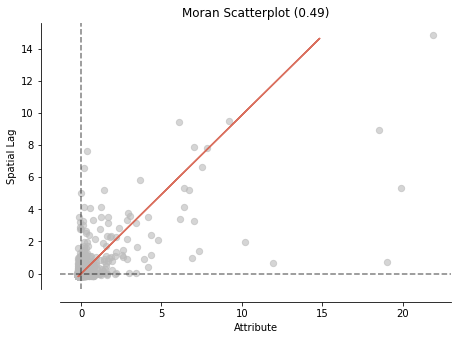

In [15]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

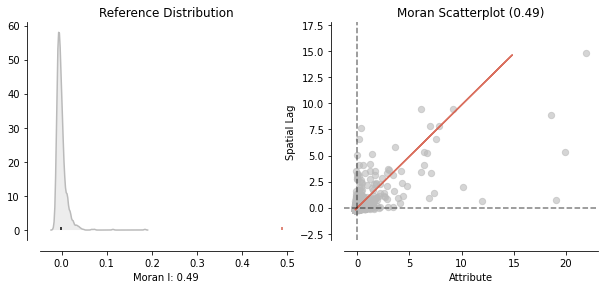

In [16]:
#Reference plots
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [17]:
#Statistical significance 
moran.p_sim

0.001

Results are statistically significant

/Users/akashyadav/Desktop/nyuclass/python3.8based/lib/python3.8/site-packages/esda/moran.py:886: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/akashyadav/Desktop/nyuclass/python3.8based/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/akashyadav/Desktop/nyuclass/python3.8based/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/akashyadav/Desktop/nyuclass/python3.8based/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


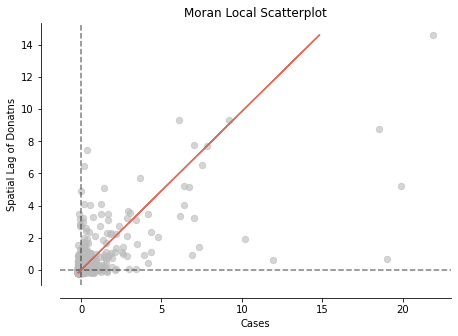

In [18]:
#Local autocorrelation and hotspot analysis
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc)
ax.set_xlabel('Cases')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

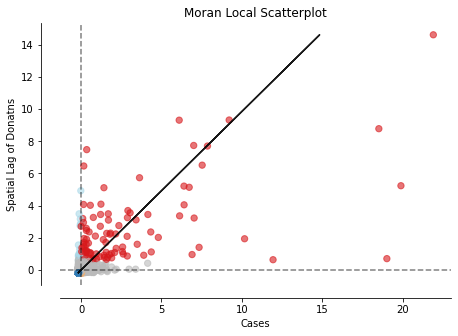

In [19]:
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Cases')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

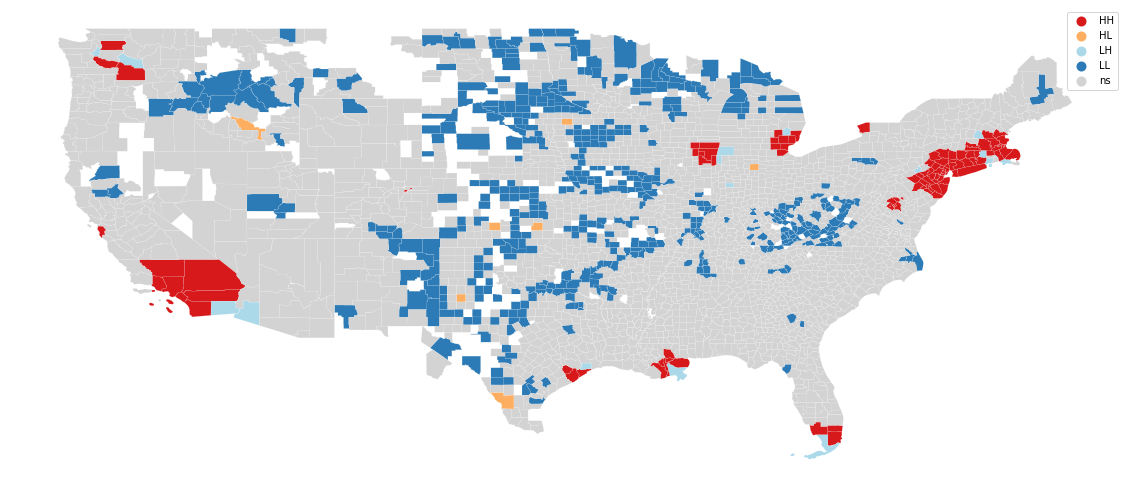

In [22]:
#Visualising the spatial clusters : HH - High-High Clustering, HL - High-Low Clustering, LL - Low-Low Clustering, ns - no clustering etc
from splot.esda import lisa_cluster

lisa_cluster(moran_loc, sdat, p=0.05, figsize = (20,15))
plt.show()

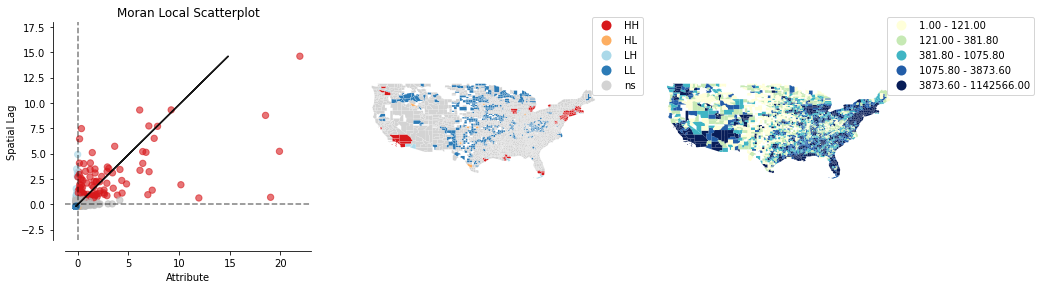

In [26]:
#All together
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(moran_loc, sdat,'cases')
plt.show()

In [20]:
f = pd.read_csv('county_spatial_latlong.csv')
f.head()

,Unnamed: 0,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,x,y
0,0,31,39,835841,31039,Cuming,Cuming County,6,H1,G4020,...,NaN,NaN,A,1477652222,10690952,41.915865,-96.788517,"POLYGON ((-97.019516 42.004097, -97.019519 42....",-96.787400,41.916403
1,1,53,69,1513275,53069,Wahkiakum,Wahkiakum County,6,H1,G4020,...,NaN,NaN,A,680962890,61582307,46.294638,-123.424458,"POLYGON ((-123.436394 46.238197, -123.447592 4...",-123.433470,46.291134
2,2,35,11,933054,35011,De Baca,De Baca County,6,H1,G4020,...,NaN,NaN,A,6016819475,29089486,34.359273,-104.368696,"POLYGON ((-104.567387 33.997566, -104.567717 3...",-104.411958,34.342414
3,3,31,109,835876,31109,Lancaster,Lancaster County,6,H1,G4020,...,30700.0,NaN,A,2169270569,22849484,40.783547,-96.688658,"POLYGON ((-96.91075099999999 40.784944, -96.91...",-96.687756,40.784174
4,4,31,129,835886,31129,Nuckolls,Nuckolls County,6,H1,G4020,...,NaN,NaN,A,1489645188,1718484,40.176492,-98.046842,"POLYGON ((-98.27366699999999 40.089399, -98.27...",-98.047185,40.176380


In [24]:
f1 = f[['NAME','x','y','STATEFP','COUNTYFP','GEOID']]
f1.head()

,NAME,x,y,STATEFP,COUNTYFP,GEOID
0,Cuming,-96.787400,41.916403,31,39,31039
1,Wahkiakum,-123.433470,46.291134,53,69,53069
2,De Baca,-104.411958,34.342414,35,11,35011
3,Lancaster,-96.687756,40.784174,31,109,31109
4,Nuckolls,-98.047185,40.176380,31,129,31129


In [25]:
f1[f1['NAME']=='Bronx']

,NAME,x,y,STATEFP,COUNTYFP,GEOID
3162,Bronx,-73.85307,40.84921,36,5,36005
